In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bostHouse = pd.read_csv("boston.csv")
bostHouse.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Data tersebut tentang prediksi harga rumah (medv) di kota Boston, fitur:
- Criminal rate (crim)
- Residential land zoned proportion (zn)
- Non-retail business acres proportion (indus)
- Is bounds with river (chas)
- Nitrogen oxides concentration (nox)
- Number rooms average (rm)
- Owner age proportion (age)
- Weighted distance to cities (dis)
- Accessibility index (rad)
- Tax rate (tax)
- Pupil-teacher ratio (ptratio)
- Black proportion (black)
- Percent lower status (lstat)


In [3]:
# split train test
from sklearn.model_selection import train_test_split

feature = bostHouse.drop(columns='medv') #dependent variables
target = bostHouse[['medv']] #independent to be predicted

# First Split pre_train and test (80:20)
feature_boston_pretrain, feature_boston_test, target_boston_pretrain, target_boston_test = train_test_split(feature, target, test_size=0.20, random_state=42)

# Second Split train and validation (80:20)
feature_boston_train, feature_boston_validation, target_boston_train, target_boston_validation = train_test_split(feature_boston_pretrain, target_boston_pretrain, test_size=0.20, random_state=42)

In [4]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_boston_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


Several features that have high vif_score
1. `nox`
2. `dis`
3. `rad`
4. `tax`

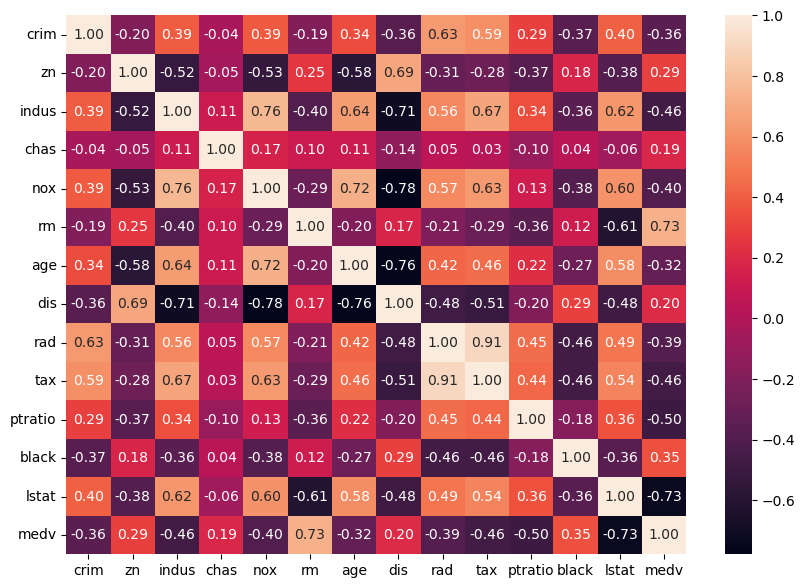

In [5]:
# heatmap correlation
boston_train = pd.concat([feature_boston_train, target_boston_train], axis=1)
corr = boston_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

several features are highly correlated :
1. `rad` and `tax`. 
2. `indus` and `nox`
3. `dis` and `age`
4. `dis` and `indus`

Handling Multicollinearity :
1. Drop `tax` or `rad`. Because `tax` have higher correlation with `medv`, we should drop `rad`.
2. Drop `indus` or `nox` or `dis`. Drop `dis` to solve `dis`-`age` problem and drop `nox` same reason as no.1

In [6]:
# drop redundant features
feature_boston_train = feature_boston_train.drop(columns=['rad','dis', 'nox'])
feature_boston_test = feature_boston_test.drop(columns=['rad','dis', 'nox'])
feature_boston_validation = feature_boston_validation.drop(columns=['rad','dis', 'nox'])

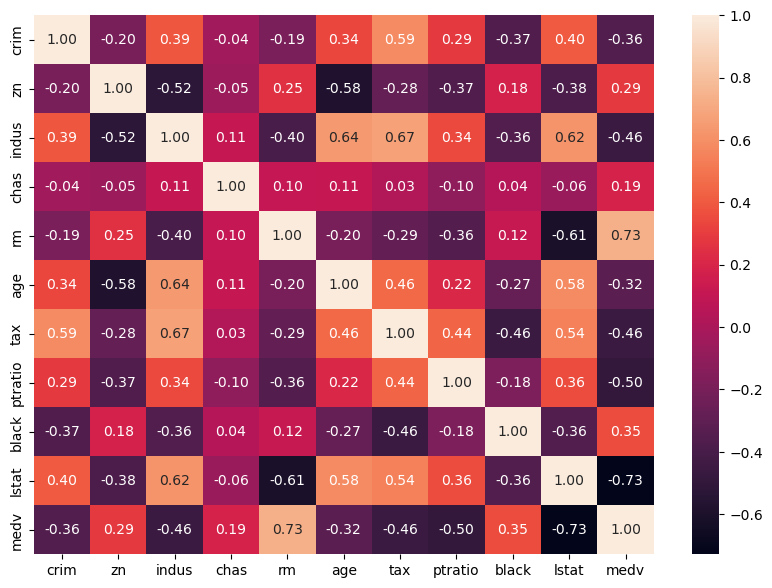

In [7]:
# Checking after cleaning multicollinearity
boston_train = pd.concat([feature_boston_train, target_boston_train], axis=1)
corr = boston_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

Very Well! now the highest correlation is `tax`-`indus` with 0.70. we can use it

In [8]:
# calculate VIF scores
X = add_constant(feature_boston_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,1.596586
2,zn,1.832693
3,indus,2.970810
4,chas,1.078919
5,rm,1.891979
6,age,2.491050
7,tax,2.827854
8,ptratio,1.480472
9,black,1.346511
10,lstat,2.935815


Proven! Let's move up

## Ridge Regression

### Model Training

In [9]:
from sklearn.linear_model import Ridge

X_boston_train = feature_boston_train.to_numpy()
y_boston_train = target_boston_train.to_numpy()
y_boston_train = y_boston_train.reshape(len(y_boston_train),)

# define model
RidgeReg = Ridge(alpha=0.1, 
                  random_state=42)

# Train model
RidgeReg.fit(X_boston_train, y_boston_train)

Ridge(alpha=0.1, random_state=42)

### Coefficients

In [10]:
# retrieve the coefficients in a nice dataframe

data = feature_boston_train
model = RidgeReg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,3.014567
1,crim,-0.051457
2,zn,-0.009201
3,indus,0.038156
4,chas,2.982360
5,rm,5.555203
6,age,0.014550
7,tax,-0.000602
8,ptratio,-0.813984
9,black,0.013172


In [11]:
# train the model
X_boston_train = feature_boston_train.to_numpy()
y_boston_train = target_boston_train.to_numpy()
y_boston_train = y_boston_train.reshape(len(y_boston_train),)

# define the model
# 4 models with 4 different alphas (lambda)
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_boston_train, y_boston_train)
ridge_reg_pointone.fit(X_boston_train, y_boston_train)
ridge_reg_one.fit(X_boston_train, y_boston_train)
ridge_reg_ten.fit(X_boston_train, y_boston_train)

Ridge(alpha=10, random_state=42)

### Finding the best Lambda on Validation set

In [12]:
from sklearn.metrics import mean_squared_error

X_boston_validation = feature_boston_validation.to_numpy()
y_boston_validation = target_boston_validation.to_numpy()
y_boston_validation = y_boston_validation.reshape(len(y_boston_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_boston_validation)
    rmse = np.sqrt(mean_squared_error(y_boston_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 5.100886202642038
RMSE of Ridge regression model with alpha = 0.1 is 5.100288438419683
RMSE of Ridge regression model with alpha = 1.0 is 5.094521787042946
RMSE of Ridge regression model with alpha = 10 is 5.05166207510316


Okay, lets choose 10 as our lambda

### Coefficients

In [13]:
best_ridge = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_boston_train.columns.tolist(),
    'coefficient':[best_ridge.intercept_] + list(best_ridge.coef_)
})

coef_df

,feature,coefficient
0,intercept,7.068423
1,crim,-0.052216
2,zn,-0.007855
3,indus,0.034094
4,chas,2.061822
5,rm,5.041802
6,age,0.020313
7,tax,-0.000312
8,ptratio,-0.845843
9,black,0.012919


### Diagnostic Study


In [14]:
from sklearn.metrics import r2_score

y_predict_train = best_ridge.predict(X_boston_train)

print('R-squared for training data is {}'.format(r2_score(y_boston_train, y_predict_train)))

R-squared for training data is 0.7279488107440679


It's quite good to know R2-Score is 0.72

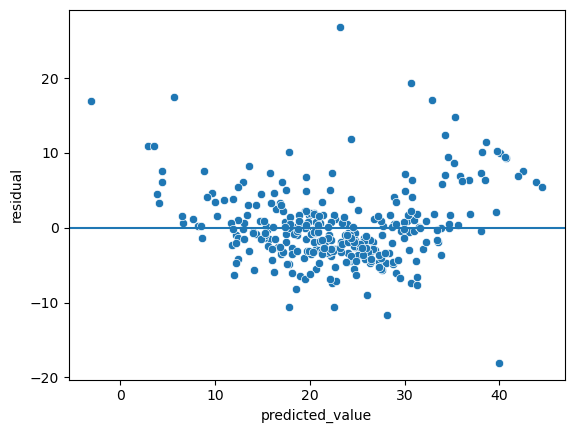

In [15]:
# calculate residuals
residual = y_boston_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Assumption:
1. Linear relationship: OK. y = 0 is enough to represent residual points.
2. Variance stable: NO. 
3. Independent residual: OK. 

### Model Evaluation


#### Training Error

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_boston_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_boston_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_boston_train, y_predict_train)))

RMSE for training data is 4.9709140124939095
MAE for training data is 3.523196953485151
MAPE for training data is 0.1745584290721267


#### Testing Error

In [17]:
# prepare prediction result on test data
X_boston_test = feature_boston_test.to_numpy()
y_predict_test = best_ridge.predict(X_boston_test)

# ground truth target
y_boston_test = target_boston_test.to_numpy()
y_boston_test = y_boston_test.reshape(len(y_boston_test),)

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_boston_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_boston_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_boston_test, y_predict_test)))

RMSE for testing data is 5.44673855240622
MAE for testing data is 3.375222443022143
MAPE for testing data is 0.18208056495930786


### Conclusion
1. Dari hasil training dan test error, terjadi kenaikan nilai RMSE namun tidak signifikan.
2. MAPE training 17% dan testing 18%, keduanya masih di bawah 20%, model tersebut sudah memiliki akurasi yang cukup baik.
3. Perbedaan yang kecil dari training ke test menunjukkan tidak terjadi overfitting yang signifikan.

Sekian :)

## Lasso Regression

In [19]:
from sklearn.linear_model import Lasso

X_boston_train = feature_boston_train.to_numpy()
y_boston_train = target_boston_train.to_numpy()
y_boston_train = y_boston_train.reshape(len(y_boston_train),)

# define model
LassoReg = Lasso(alpha=0.1, 
                  random_state=42)

# Train model
LassoReg.fit(X_boston_train, y_boston_train)

Lasso(alpha=0.1, random_state=42)

In [20]:
# retrieve the coefficients in a nice dataframe

data = feature_boston_train
model = LassoReg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,4.966611
1,crim,-0.052024
2,zn,-0.007849
3,indus,0.038162
4,chas,1.513240
5,rm,5.281192
6,age,0.019209
7,tax,-0.000454
8,ptratio,-0.822748
9,black,0.013190


In [21]:
# train the model
X_boston_train = feature_boston_train.to_numpy()
y_boston_train = target_boston_train.to_numpy()
y_boston_train = y_boston_train.reshape(len(y_boston_train),)

# define the model
# 4 models with 4 different alphas (lambda)
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_boston_train, y_boston_train)
lasso_reg_pointone.fit(X_boston_train, y_boston_train)
lasso_reg_one.fit(X_boston_train, y_boston_train)
lasso_reg_ten.fit(X_boston_train, y_boston_train)

Lasso(alpha=10, random_state=42)

### Finding best Lambda

In [22]:
from sklearn.metrics import mean_squared_error

X_boston_validation = feature_boston_validation.to_numpy()
y_boston_validation = target_boston_validation.to_numpy()
y_boston_validation = y_boston_validation.reshape(len(y_boston_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_boston_validation)
    rmse = np.sqrt(mean_squared_error(y_boston_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 5.0975145904984664
RMSE of Ridge regression model with alpha = 0.1 is 5.080169848064391
RMSE of Ridge regression model with alpha = 1.0 is 4.988309999786156
RMSE of Ridge regression model with alpha = 10 is 5.426622694252769


Lambda = 0.1 is the best fit for this model

### Coefficient

In [23]:
best_lasso = lasso_reg_pointone

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_boston_train.columns.tolist(),
    'coefficient':[best_lasso.intercept_] + list(best_lasso.coef_)
})

coef_df

,feature,coefficient
0,intercept,4.966611
1,crim,-0.052024
2,zn,-0.007849
3,indus,0.038162
4,chas,1.513240
5,rm,5.281192
6,age,0.019209
7,tax,-0.000454
8,ptratio,-0.822748
9,black,0.013190


### Diagnostic Study

In [24]:
from sklearn.metrics import r2_score

y_predict_train = best_lasso.predict(X_boston_train)

print('R-squared for training data is {}'.format(r2_score(y_boston_train, y_predict_train)))

R-squared for training data is 0.7275852984225231


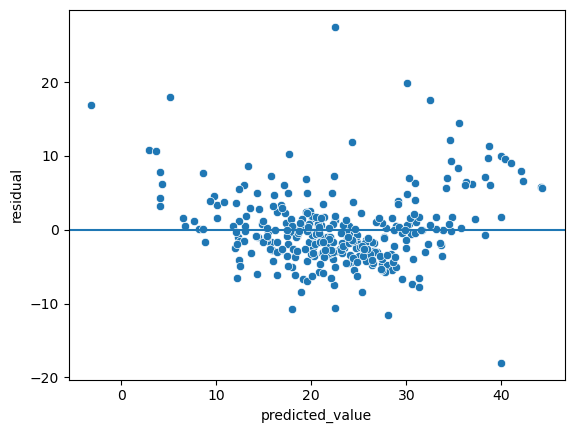

In [25]:
# calculate residuals
residual = y_boston_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Assumption : Just the same as Ridge Regression

### Model Evaluation

#### Training Error

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_boston_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_boston_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_boston_train, y_predict_train)))

RMSE for training data is 4.974233948863918
MAE for training data is 3.5063033082249904
MAPE for training data is 0.1744400138484652


#### Testing Error

In [27]:
# prepare prediction result on test data
X_boston_test = feature_boston_test.to_numpy()
y_predict_test = best_ridge.predict(X_boston_test)

# ground truth target
y_boston_test = target_boston_test.to_numpy()
y_boston_test = y_boston_test.reshape(len(y_boston_test),)

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_boston_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_boston_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_boston_test, y_predict_test)))

RMSE for testing data is 5.44673855240622
MAE for testing data is 3.375222443022143
MAPE for testing data is 0.18208056495930786


### Conclusion
1. Dari hasil training dan test error, terjadi kenaikan nilai RMSE namun tidak signifikan.
2. MAPE training 17% dan testing 18%, keduanya masih di bawah 20%, model tersebut sudah memiliki akurasi yang cukup baik.
3. Perbedaan yang kecil dari training ke test menunjukkan tidak terjadi overfitting.

Sekian :)

In [29]:
input_data = np.array([[0.00632, 385, 6.575, 65, 4.0900, 1, 296, 15, 395, 5]])

test = LassoReg.predict(input_data)
test2 = RidgeReg.predict(input_data)

print(f"Prediksi dari data ngasal diatas, maka harga rumah menurut lasso: {test[0]} dollar")
print(f"Prediksi dari data ngasal diatas, maka harga rumah menurut ridge: {test2[0]} dollar")

Prediksi dari data ngasal diatas, maka harga rumah menurut lasso: 112.2842713506051 dollar
Prediksi dari data ngasal diatas, maka harga rumah menurut ridge: 206.64175477491318 dollar
